# Plot HMR rivers, basins and elevation

### Dependencies

In [1]:
# conda install geopandas shapely rasterio -c conda-forge 

In [338]:
from pathlib import Path
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import Polygon
import rasterio, rasterio.mask, rasterio.plot

## DATA

In [3]:
# Data and figures dirs should already exist in repo. Modify paths if needed.
FIGURES_DIR = Path("../figures")
DATA_DIR = Path("../data")
assert DATA_DIR.exists()
assert FIGURES_DIR.exists()
DATA_DIR.mkdir(exist_ok=True)
FIGURES_DIR.mkdir(exist_ok=True)

In [4]:
# url data paths and constants
SRTM_DATA = DATA_DIR / "HMR_SRTM15.tif"
URL_COORDS_BASE = "https://raw.githubusercontent.com/eaton-lab/pedicularis-phylog/refs/heads/main/data/coords/"
URL_BASINS = "https://data.hydrosheds.org/file/hydrobasins/standard/hybas_as_lev01-12_v1c.zip"  # 359 Mb
URL_RIVERS = "https://data.hydrosheds.org/file/HydroRIVERS/HydroRIVERS_v10_as.gdb.zip"          # 98 Mb
URL_ELEV = "https://topex.ucsd.edu/pub/srtm15_plus/SRTM15_V2.6.nc"                              # 6.1 Gb (discarded after clipping)
URLS = [URL_BASINS, URL_RIVERS, URL_ELEV]
BOUNDS_HMR = (94.5, 27.0, 103.5, 34.5)
CRS = "EPSG:4326"
PREFIXES = [
    "crano", "longi", "rhinanth", "lachno",
]

#### Load bounding box polygon

In [5]:
# Create a bounding box on our study region
bbox = Polygon([
    (BOUNDS_HMR[0], BOUNDS_HMR[1]),
    (BOUNDS_HMR[0], BOUNDS_HMR[3]), 
    (BOUNDS_HMR[2], BOUNDS_HMR[3]),
    (BOUNDS_HMR[2], BOUNDS_HMR[1]),
])

## Download data
This cell will download three datasets if they don't yet exist locally: basins, rivers, and elevation. 

In [6]:
def download_stream(url: str, outdir: Path) -> None:
    """Download data from the link, write locally. Files do not need to be unzipped."""
    # get filename from url and set new path 
    filename = url.split("/")[-1]
    newpath = outdir / filename

    # download files if not already present in outdir
    if newpath.exists():
        print(f"file {newpath} exists locally.")
    else:
        with requests.get(url, allow_redirects=True, stream=True) as response:
            response.raise_for_status()
            with open(newpath, "wb") as out:
                for chunk in response.iter_content(chunk_size=8192):
                    out.write(chunk)
            print(f"downloaded: {newpath}")

#### Download basin vectors zip file

In [7]:
download_stream(URL_BASINS, DATA_DIR)

file ../data/hybas_as_lev01-12_v1c.zip exists locally.


#### Download rivers vectors zip file

In [8]:
# download river vectors zip file
download_stream(URL_RIVERS, DATA_DIR)

file ../data/HydroRIVERS_v10_as.gdb.zip exists locally.


#### Download SRTM raster file

In [10]:
# if local clipped file exists, load that
if SRTM_DATA.exists():
    print("clipped SRTM file exists locally")

# else, download large file, save clipped version, and discard the big one.
else:
    # download big file temporarily
    big_file_srtm = DATA_DIR / URL_ELEV.split("/")[-1]
    if big_file_srtm.exists():
        print(f"big SRTM file exists locally: {big_file_srtm}")
    else:
        download_stream(URL_ELEV, DATA_DIR)
        print(f"downloaded big SRTM file: {big_file_srtm}")
           
    # create clipped file from big file
    with rasterio.open(big_file_srtm, crs=CRS) as src:
        out_image, out_transform = rasterio.mask.mask(src, [bbox], crop=True)
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "crs": CRS,
        })
        # write clipped file
        with rasterio.open(SRTM_DATA, "w", **out_meta) as dest:
            dest.write(out_image)
        print(f"saved clipped SRTM file: {SRTM_DATA}")
        
    # discard big file
    if big_file_srtm.exists():
        big_file_srtm.unlink()
        print("removed big srtm file")

clipped SRTM file exists locally


## DATA PREP

#### Get sample coordinates

In [11]:
coords_dfs = []
for pre in PREFIXES:
    coords = pd.read_csv(URL_COORDS_BASE + f"{pre}_coords.csv")
    coords = coords[coords["group"] != -1].reset_index(drop=True)
    points = gpd.points_from_xy(coords["longitude"], coords["latitude"], crs=CRS)
    geodata = gpd.GeoDataFrame(coords, crs=CRS, geometry=points)
    coords_dfs.append(geodata)

# concatenate all dfs
geodata = pd.concat(coords_dfs)
print(geodata.shape)
geodata.head()

(277, 10)


,ID,latitude,longitude,label,group,notes,geometry,mincov75-missing,old_group,missing-mincov75
0,DE108,30.063972,101.316639,cranolopha,1,NaN,POINT (101.31664 30.06397),NaN,NaN,NaN
1,DE167,30.740639,101.334361,cranolopha,1,NaN,POINT (101.33436 30.74064),NaN,NaN,NaN
2,DE177,30.846917,101.274333,cranolopha,1,NaN,POINT (101.27433 30.84692),NaN,NaN,NaN
3,DE186,31.201028,100.857889,cranolopha,1,NaN,POINT (100.85789 31.20103),NaN,NaN,NaN
4,DE196,31.657500,100.701306,cranolopha,2,NaN,POINT (100.70131 31.6575),NaN,NaN,NaN


#### Load rivers and clip to bounding box

In [30]:
# path to rivers zip file
rivers_file = DATA_DIR / URL_RIVERS.split("/")[-1]

# load as geodataframe
rivers = gpd.read_file(rivers_file, bbox=bbox).to_crs(CRS).clip(bbox)

# keep only big rivers (up to ORD_FLOW 8 also looks good)
rivers = rivers.loc[rivers["ORD_FLOW"] < 6]

# scale river sizes for visualization based on dist up
left_span = np.amax(rivers["DIST_UP_KM"]) - np.amin(rivers["DIST_UP_KM"])
right_span = 0.6 - 0.005
value_scaled = (rivers["DIST_UP_KM"] - np.amin(rivers["DIST_UP_KM"])) / left_span
rivers.loc[:, "LW_DIST_UP_KM"] = 0.005 + (value_scaled * right_span)

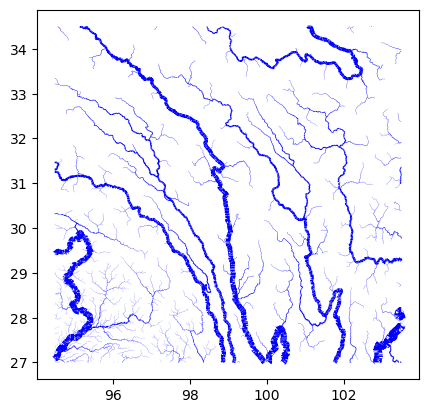

In [31]:
# examine
rivers.plot(color="blue", lw=rivers["LW_DIST_UP_KM"] * 10, edgecolor="face");

#### Load basins rasters

In [14]:
# create a dict with dataframes of basins at different levels of detail
basins_file = DATA_DIR / URL_BASINS.split("/")[-1]
basins = {}
for i in range(4, 7):
    basin = gpd.read_file(basins_file, layer=f"hybas_as_lev{i:02d}_v1c").to_crs(CRS)
    basins[i] = basin.clip(bbox)

In [337]:
# set some custom colors to basins5
basins[5].reset_index(drop=True, inplace=True)
basins[5]['color'] = "none"
basins[5].loc[1, 'color'] = 'orange'  # Salween
basins[5].loc[12, 'color'] = 'blue'   # Irrawady
basins[5].loc[5, 'color'] = 'cyan'    # Lancang
basins[5].loc[15, 'color'] = 'cyan'   # upper left Lancang
basins[5].loc[17, 'color'] = 'cyan'   # upper center Lancang
basins[5].loc[21, 'color'] = 'cyan'   # upper right Lancang 
basins[5].loc[22, 'color'] = 'cyan'   # upper right Lancang
basins[5].loc[14, 'color'] = 'purple' # Jinsha
basins[5].loc[19, 'color'] = 'yellow' # Yalong
basins[5].loc[23, 'color'] = 'green'  # Huang
basins[5].loc[24, 'color'] = 'green'  # Huang
basins[5].loc[25, 'color'] = 'green'  # Huang
basins[5].loc[20, 'color'] = 'red'    # Dadu

In [16]:
# create some other extra custom basin boundary gdfs

# get the Yalong basin level 6 boundaries
YALONG_PFAF = str(int(basins[5].loc[19].PFAF_ID))
mask = basins[6].loc[:, "PFAF_ID"].astype(str).str.startswith(YALONG_PFAF)
basins_yalong = basins[6].loc[mask]

# get the Jinsha basin level 6 boundaries
JINSHA_PFAF = str(int(basins[5].loc[14].PFAF_ID))
mask = basins[6].loc[:, "PFAF_ID"].astype(str).str.startswith(JINSHA_PFAF)
basins_jinsha = basins[6].loc[mask]

# get the Lancang basin level 6 boundaries
LANCANG_PFAFs = [str(int(i)) for i in basins[5].loc[[5, 15, 17, 21, 22]].PFAF_ID]
mask = basins[6].loc[:, "PFAF_ID"].astype(str).apply(lambda x: any(x.startswith(pre) for pre in LANCANG_PFAFs))
basins_lancang = basins[6].loc[mask]

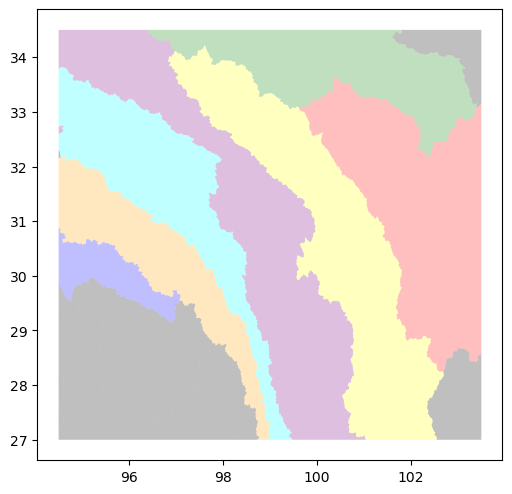

In [329]:
# example level 5 basin colors
fig, ax = plt.subplots(figsize=(6, 6))
basins[5].plot(ax=ax, edgecolor="none", alpha=0.25, facecolor=basins[5]["color"]);

# example adding a few level 6 boundaries
# basins_jinsha.boundary.plot(ax=ax, edgecolor="#262626", ls='-')
# basins_yalong.boundary.plot(ax=ax, edgecolor="#262626", ls='-');

#### Load clipped SRTM raster

In [332]:
with rasterio.open(SRTM_DATA, crs=CRS) as src:
    assert CRS == src.crs
    topo_transform = src.transform
    topo = src.read(1)

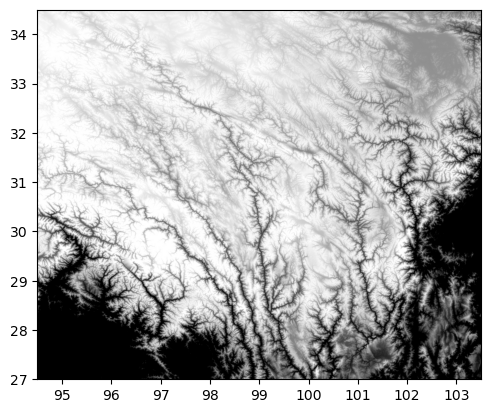

In [333]:
rasterio.plot.show(topo, cmap="Greys_r", transform=topo_transform, vmin=2000, vmax=5000);

## Combined plot
The darker shaded regions represent "generally" unsuitable elevations for *Pedicularis*.

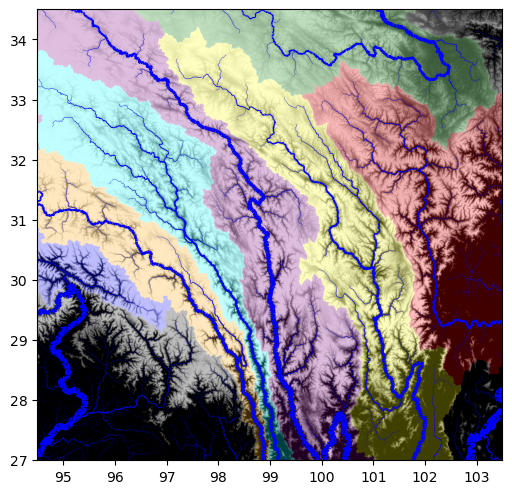

In [334]:
fig, ax = plt.subplots(figsize=(6, 6))
rasterio.plot.show(topo, ax=ax, cmap="Greys_r", transform=topo_transform, vmin=3000, vmax=4750)
basins[5].plot(ax=ax, edgecolor="none", alpha=0.25, facecolor=basins[5]["color"])
rivers.plot(ax=ax, color="blue", lw=rivers["LW_DIST_UP_KM"] * 10, edgecolor="face")
plt.savefig(FIGURES_DIR / "hmr_topo_basins5.png", dpi=300, format="png")
plt.show()

## Highlight high elevations

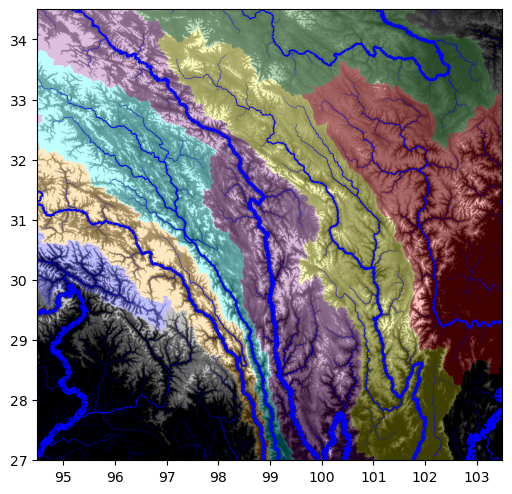

In [335]:
fig, ax = plt.subplots(figsize=(6, 6))
elev = topo.copy()
elev[elev > 4750] = 10000
rasterio.plot.show(elev, ax=ax, cmap="Greys_r", transform=topo_transform, vmin=2750, vmax=6500)
basins[5].plot(ax=ax, edgecolor="none", alpha=0.25, facecolor=basins[5]["color"])
rivers.plot(ax=ax, color="blue", lw=rivers["LW_DIST_UP_KM"] * 10, edgecolor="face")
plt.savefig(FIGURES_DIR / "hmr_topo_basins5_high4750.png", dpi=300, format="png")
plt.show()

### Add sampling points

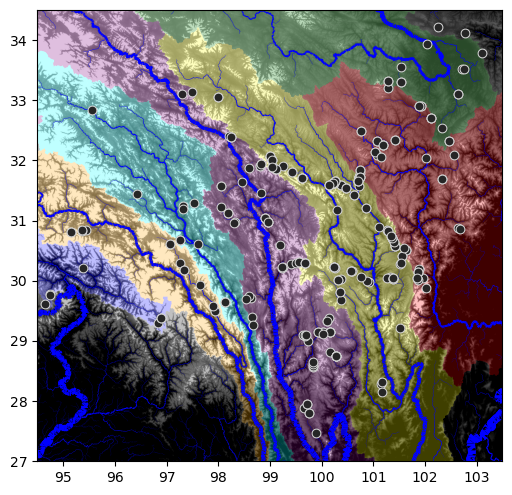

In [336]:
fig, ax = plt.subplots(figsize=(6, 6))
elev = topo.copy()
elev[elev > 4750] = 10000
rasterio.plot.show(elev, ax=ax, cmap="Greys_r", transform=topo_transform, vmin=2750, vmax=6500)
basins[5].plot(ax=ax, edgecolor="none", alpha=0.25, facecolor=basins[5]["color"])
rivers.plot(ax=ax, color="blue", lw=rivers["LW_DIST_UP_KM"] * 10, edgecolor="face")
geodata.plot(ax=ax, markersize=40, facecolor="#262626", edgecolor="lightgrey", linewidths=0.75, zorder=10)
plt.savefig(FIGURES_DIR / "hmr_topo_basins5_high4750_points", dpi=300, format="png")
plt.show()